<a href="https://colab.research.google.com/github/andrejobuljen/JaxPM-Hi-Fi-mocks/blob/main/notebooks/forward_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git
!pip install --quiet numpyro
!pip install --quiet git+https://github.com/andrejobuljen/JaxPM-Hi-Fi-mocks.git
!pip install --quiet corner
# !pip install --quiet chainconsumer #==0.33.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%pylab inline
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum, _initialize_pk, cross_correlation
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces, linear_field_from_IC, linear_field_just_IC, generate_d12_bias, whitenoise, expected_noise_level
from jaxpm.kernels import fftk, tidal_G2
from jaxpm.growth import growth_factor, growth_rate, dGfa

Populating the interactive namespace from numpy and matplotlib


<ipython-input-4-078c36b9c894>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum((kk / box_size[0] * mesh_shape[0])**2 for kk in kvec)


kmax = 0.251


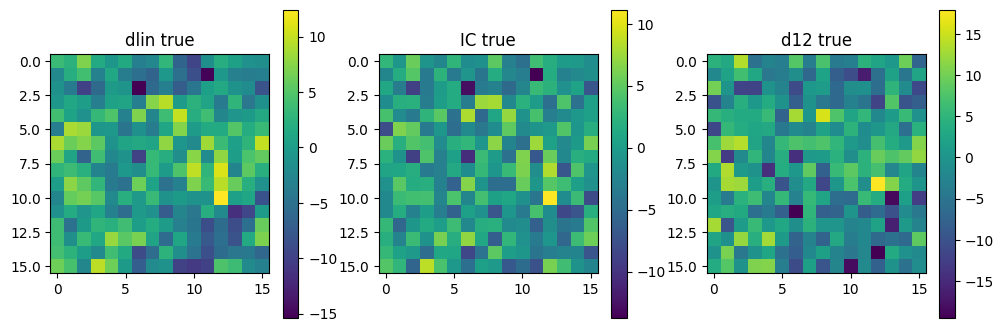

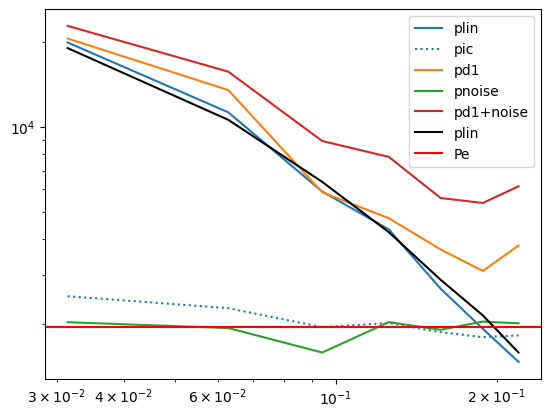

In [4]:
Ng = 16
L  = 200.
Pe = expected_noise_level(Ng, L)

mesh_shape= [Ng, Ng, Ng]  # Also number of particles
box_size  = [L, L, L] # in Mpc/h
kmin = jnp.pi/box_size[0]
dk = 2*jnp.pi/box_size[0]

kvec = fftk([mesh_shape[0], mesh_shape[0], mesh_shape[0]])
kmesh = sum((kk / box_size[0] * mesh_shape[0])**2 for kk in kvec)
kmesh = jnp.sqrt(kmesh)

kmax = np.pi/ box_size[0] * Ng
print ("kmax = %.3f"%kmax)

# Create particles (this we don't need to do at each step)
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 2, 500)
pk = jc.power.linear_matter_power(jc.Planck15(), k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# true cosmology and bias params
omc_true = jc.Planck15().Omega_c
h_true = jc.Planck15().h
s8_true = jc.Planck15().sigma8
b1_true = 1.0
b2_true = -0.5

# Create initial conditions and compute fft which will be used when IC fixed
dlin_true = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(1))
IC_true   = linear_field_just_IC(mesh_shape, box_size, seed=jax.random.PRNGKey(1))
d12_true = generate_d12_bias(jc.Planck15(), dlin_true, particles, b1_true, b2_true)
IC_true_inv = jnp.fft.rfftn(IC_true)

figure(figsize=[12,4])
subplot(131)
cax = imshow(dlin_true.sum(axis=0)); colorbar(cax)
title('dlin true')
subplot(132)
cax = imshow(IC_true.sum(axis=0)); colorbar(cax)
title('IC true')
subplot(133)
cax = imshow(d12_true.sum(axis=0)); colorbar(cax)
title('d12 true')
show()

plin = power_spectrum(dlin_true, kmin=kmin, dk=dk, boxsize=box_size)
pic  = power_spectrum(IC_true, kmin=kmin, dk=dk, boxsize=box_size)
pd12  = power_spectrum(d12_true, kmin=kmin, dk=dk, boxsize=box_size)

# add noise

noise = whitenoise(Pe, mesh_shape, box_size, seed=jax.random.PRNGKey(5))
d12_true_noise = d12_true + noise

pnoise = power_spectrum(noise, kmin=kmin, dk=dk, boxsize=box_size)
pd12_noise = power_spectrum(d12_true_noise, kmin=kmin, dk=dk, boxsize=box_size)

kmeas = pd12[0]

loglog(plin[0], plin[1], label = 'plin')
loglog(pic[0], pic[1], 'C0:', label = 'pic')
loglog(kmeas, pd12[1], label = 'pd1')
loglog(kmeas, pnoise[1], label = 'pnoise')
loglog(kmeas, pd12_noise[1], label = 'pd1+noise')
loglog(plin[0], pk_fn(plin[0]), 'k', label = 'plin')
axhline(expected_noise_level(Ng,L), c='red', label = 'Pe')
legend(loc=0)

In [5]:
kmeas = pd12[0]
valid_k = kmeas < kmax
nmodes = kmeas**2 * dk * box_size[0]**3/(4*jnp.pi**2)

In [6]:
def nonlin_model_IC_cosmo(
             N=mesh_shape[0],     # number of pixels on the map
             L=box_size[0],              # box size in Mpc/h
             obs=None):

    # Sampling cosmology
    omc = numpyro.sample('omc', dist.Normal(0., 1.0))* 0.1*omc_true + omc_true
    h   = numpyro.sample('h',  dist.Normal(0., 1.0)) * 0.1*h_true   + h_true
    b1  = numpyro.sample('b1', dist.Normal(0., 1.0)) * 0.1*b1_true  + b1_true
    b2  = numpyro.sample('b2', dist.Normal(0., 1.0)) * 0.1*b2_true  + b2_true

    cosmo_loc = jc.Planck15(Omega_c=omc, h=h)

    pk_loc = jc.power.linear_matter_power(cosmo_loc, k)
    pk_loc_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk_loc).reshape(x.shape)
    pkmesh_loc = pk_loc_fn(kmesh) * (N ** 3) / (L ** 3)

    # Sampling latent variables / ICs
    IC = numpyro.sample('IC', dist.MultivariateNormal(loc=jnp.zeros((N,N,N)), precision_matrix=jnp.eye(N)))

    field = jnp.fft.rfftn(IC) * jnp.sqrt(pkmesh_loc)
    field = jnp.fft.irfftn(field)

    d12 = numpyro.deterministic('d12', generate_d12_bias(cosmo_loc, field, particles, b1, b2))

    Pd1 = numpyro.deterministic('Pd1', power_spectrum(d12, kmin=kmin, dk=dk, boxsize=[L,L,L])[1][valid_k])

    diff = d12 - obs
    Pdiff = numpyro.deterministic('Pdiff', power_spectrum(diff, kmin=kmin, dk=dk, boxsize=[L,L,L])[1][valid_k])

    cov_fl = 0.5/nmodes[valid_k] * Pe

    numpyro.sample('y', dist.Normal(jnp.sqrt(Pdiff), jnp.sqrt(cov_fl)), obs=jnp.zeros(len(Pdiff)))

In [ ]:
nwarm, nsamp, nchain, max_td = 500, 500, 1, 10

sampler_nonlin_IC_cosmo = numpyro.infer.MCMC(
    numpyro.infer.NUTS(nonlin_model_IC_cosmo),
    num_warmup=nwarm,
    num_samples=nsamp,
    num_chains=nchain,
    progress_bar=True)
sampler_nonlin_IC_cosmo.run(jax.random.PRNGKey(24), obs=d12_true_noise)

sample: 100%|██████████| 1000/1000 [47:21<00:00,  2.84s/it, 255 steps of size 2.41e-02. acc. prob=0.80]
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [ ]:
results_nonlin_IC_cosmo = sampler_nonlin_IC_cosmo.get_samples()

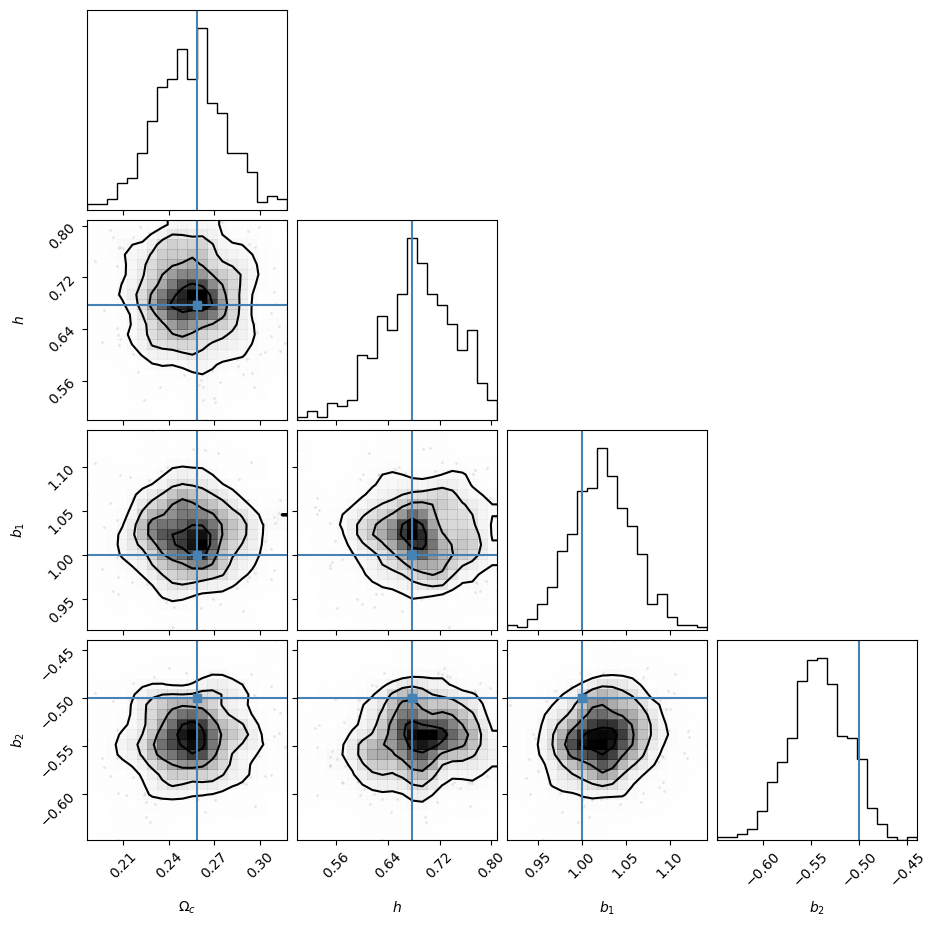

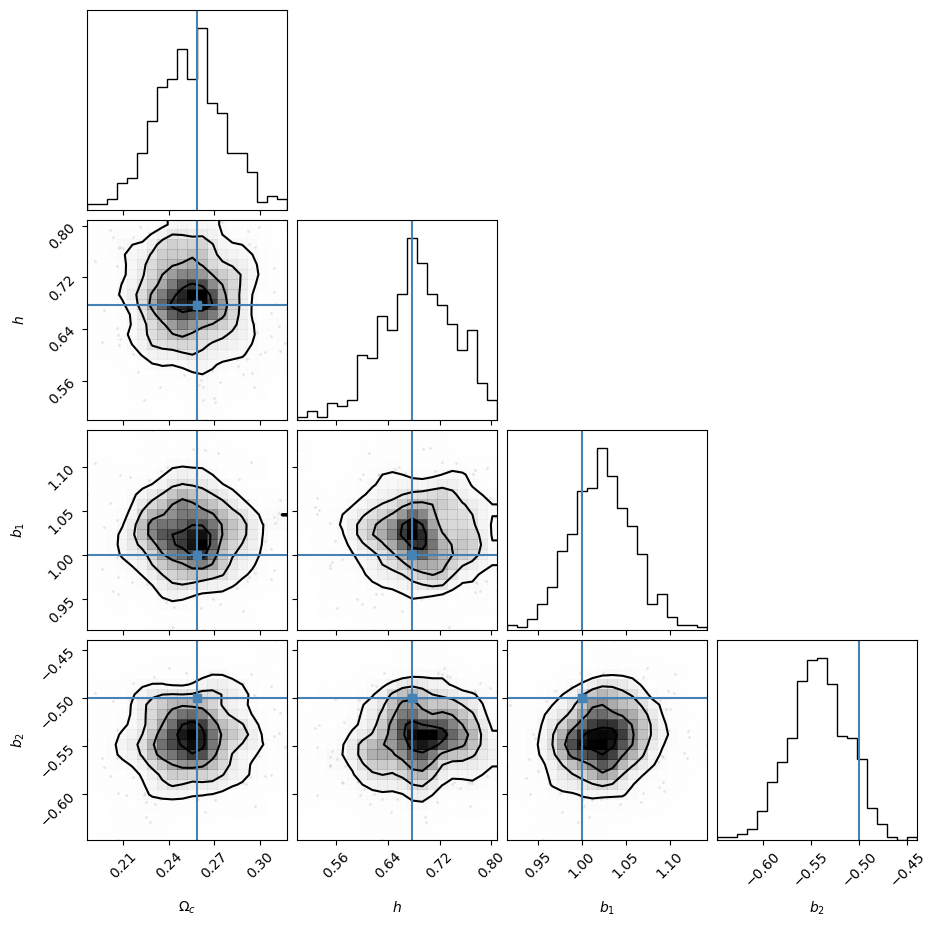

In [ ]:
import corner

corner.corner(np.stack([results_nonlin_IC_cosmo['omc']*0.1*omc_true + omc_true, \
                      results_nonlin_IC_cosmo['h']*0.1*h_true     + h_true, \
                      results_nonlin_IC_cosmo['b1']*0.1*b1_true   + b1_true, \
                      results_nonlin_IC_cosmo['b2']*0.1*b2_true   + b2_true], axis=1), \
              truths=[omc_true, h_true, b1_true, b2_true], labels=['$\\Omega_c$', '$h$', '$b_1$', '$b_2$'],
              smooth=1)

Text(0.5, 1.0, 'mean of samples')

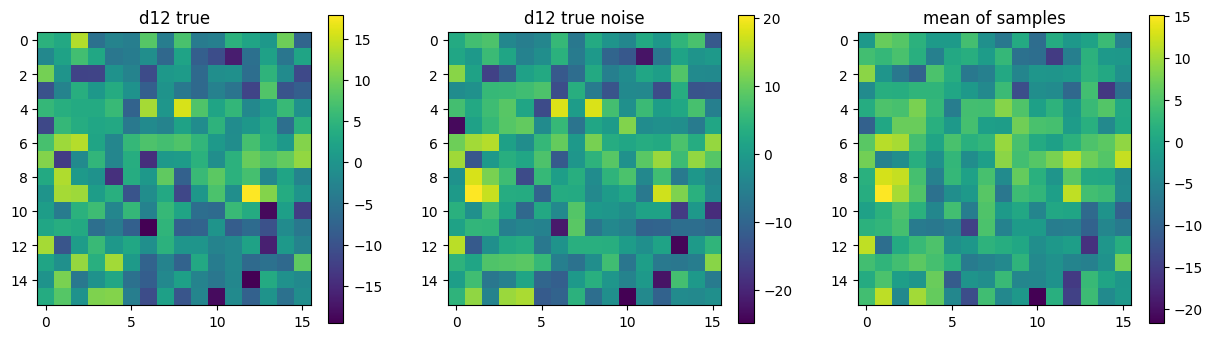

In [ ]:
figure(figsize=[15,4])
subplot(131)
cax = imshow(d12_true[...].sum(axis=0)); colorbar()
title('d12 true')
subplot(132)
cax = imshow(d12_true_noise[...].sum(axis=0)); colorbar()
title('d12 true noise')
subplot(133)
cax = imshow(results_nonlin_IC_cosmo['d12'].mean(axis=0)[...].sum(axis=0)); colorbar()
title('mean of samples')


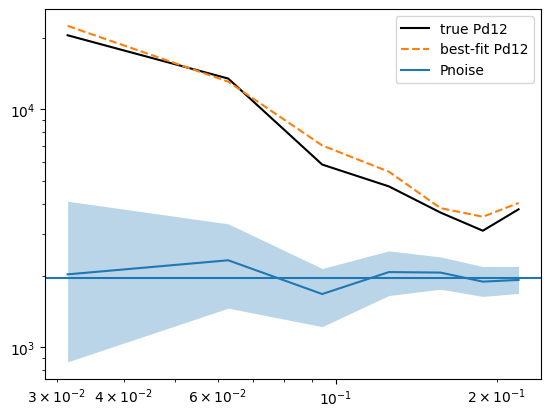

In [ ]:
# loglog(plin[0][valid_k], plin[1][valid_k], 'k')
loglog(pd12[0][valid_k], pd12[1][valid_k], 'k', label = 'true Pd12')
loglog(pd12[0][valid_k], np.percentile(results_nonlin_IC_cosmo['Pd1'], 50, axis=0), 'C1--', label = 'best-fit Pd12')
loglog(pd12[0][valid_k], np.percentile(results_nonlin_IC_cosmo['Pdiff'], 50, axis=0), 'C0', label='Pnoise')
fill_between(pd12[0][valid_k], *np.percentile(results_nonlin_IC_cosmo['Pdiff'], [1,99], axis=0), alpha=0.3, lw=0, color='C0')
legend(loc=0)
# loglog(pd12[0][valid_k], np.percentile(pksampler_lin_fixIC_cosmo.get_samples()['Pfield'], 50, axis=0), 'C2--')
# fill_between(pd1[0][valid_k], *np.percentile(sampler_lin_fixIC_cosmo.get_samples()['Pf'], [5,95], axis=0), alpha=0.3, lw=0, color='C1')
# fill_between(pd1[0][valid_k], *np.percentile(pksampler_lin_fixIC_cosmo.get_samples()['Pfield'], [5,95], axis=0), alpha=0.3, lw=0, color='C2')
# fill_between(pd1[0][valid_k], *np.percentile(sampler_lin_freeIC_cosmo.get_samples()['Pdiff'], [1,99], axis=0), alpha=0.3, lw=0, color='C3')
axhline(Pe)
show()

In [ ]:
# # import matplotlib
# # matplotlib.rcParams['text.usetex'] = True

# # !pip install --quiet chainconsumer==0.33

# from chainconsumer import ChainConsumer#, Chain
# c = ChainConsumer()

# # chain = Chain.from_numpyro(results_nonlin_IC_cosmo, "numpyro chain", color="teal")
# # consumer = ChainConsumer().add_chain(chain)

# c.add_chain(np.stack([results_nonlin_IC_cosmo['omc']*0.1*omc_true + omc_true, \
#                       results_nonlin_IC_cosmo['h']*0.1*h_true     + h_true, \
#                       results_nonlin_IC_cosmo['b1']*0.1*b1_true   + b1_true, \
#                       results_nonlin_IC_cosmo['b2']*0.1*b2_true   + b2_true], axis=1),\
#                       parameters=['$omc$', 'h', 'b1', 'b2'], name='free IC nonlin cosmo bias', kde=True)
# fig = c.plotter.plot(figsize="column", truth=[omc_true, h_true, b1_true, b2_true])

In [ ]:
# def tidal_G2(delta):
#     delta_k = jnp.fft.rfftn(delta)
#     out_rfield = - delta**2
#     kvec = fftk(delta.shape)
#     kk = sum(ki**2 for ki in kvec)
#     kk[kk == 0] = 1

#     for i in range(3):
#         for j in range(i, 3):
#             dij_k = delta_k * kvec[i] * kvec[j] / kk
#             dij_x = jnp.fft.irfftn(dij_k)

#             if i == j:
#                 fac = 1.0
#             else:
#                 fac = 2.0
#             out_rfield += fac * dij_x**2

#     return out_rfield

# def lpt_loc(cosmo, initial_conditions, positions, a):
#     """
#     Computes first order LPT displacement
#     """
#     initial_force = pm_forces(positions, delta=initial_conditions)
#     a = jnp.atleast_1d(a)
#     dx = growth_factor(cosmo, a) * initial_force
#     return dx

# def generate_d12_bias(cosmo, delta_ic, particles, b1, b2):

#     weights1 = cic_read(delta_ic, particles)
#     weights1 -= weights1.mean()

#     weights2 = weights1**2
#     weights2 -= weights2.mean()

#     # Move the particles using displacement field
#     dx = lpt_loc(cosmo, delta_ic, particles, a=1.0)
#     pos = particles + dx

#     d1 = compensate_cic(cic_paint(jnp.zeros(delta_ic.shape), pos, weights1))
#     d2 = compensate_cic(cic_paint(jnp.zeros(delta_ic.shape), pos, weights2))

#     return b1*d1 + b2*d2

# def power_spectrum_loc(field, kmin=5, dk=0.5, boxsize=False):
#     """
#     Calculate the powerspectra given real space field

#     Args:

#         field: real valued field
#         kmin: minimum k-value for binned powerspectra
#         dk: differential in each kbin
#         boxsize: length of each boxlength (can be strangly shaped?)

#     Returns:

#         kbins: the central value of the bins for plotting
#         power: real valued array of power in each bin

#     """
#     shape = field.shape
#     nx, ny, nz = shape

#     #initialze values related to powerspectra (mode bins and weights)
#     dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape, boxsize, kmin, dk)

#     #fast fourier transform
#     fft_image = jnp.fft.fftn(field)

#     #absolute value of fast fourier transform
#     pk = jnp.real(fft_image * jnp.conj(fft_image))

#     #calculating powerspectra
#     real = jnp.real(pk).reshape([-1])
#     imag = jnp.imag(pk).reshape([-1])

#     Psum = jnp.bincount(dig, weights=(W.flatten() * imag), length=xsum.size) * 1j
#     Psum += jnp.bincount(dig, weights=(W.flatten() * real), length=xsum.size)

#     P = ((Psum / Nsum)[1:-1] * jnp.array(boxsize).prod()).astype('float32')

#     # jnp.array(box_size).prod()

#     #normalization for powerspectra
#     norm = jnp.prod(np.array(shape[:])).astype('float32')**2

#     #find central values of each bin
#     kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2

#     return kbins, P / norm

# def cross_correlation(field1, field2, kmin=5, dk=0.5, boxsize=False):
#     shape = field1.shape
#     nx, ny, nz = shape

#     #initialze values related to powerspectra (mode bins and weights)
#     dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape, boxsize, kmin, dk)

#     #fast fourier transform
#     fft_image1 = jnp.fft.fftn(field1)
#     fft_image2 = jnp.fft.fftn(field2)

#     #absolute value of fast fourier transform
#     pk = jnp.real(fft_image1 * jnp.conj(fft_image2))

#     #calculating powerspectra
#     real = jnp.real(pk).reshape([-1])
#     imag = jnp.imag(pk).reshape([-1])

#     Psum = jnp.bincount(dig, weights=(W.flatten() * imag), length=xsum.size) * 1j
#     Psum += jnp.bincount(dig, weights=(W.flatten() * real), length=xsum.size)

#     P = ((Psum / Nsum)[1:-1] * jnp.array(boxsize).prod()).astype('float32')

#     #normalization for powerspectra
#     norm = jnp.prod(np.array(shape[:])).astype('float32')**2

#     #find central values of each bin
#     kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2

#     return kbins, P / norm

# def linear_field_from_IC(IC_field, box_size, pk):
#     """
#     obtain linear field from IC
#     """

#     mesh_shape = IC_field.shape

#     kvec = fftk(mesh_shape)
#     kmesh = sum((kk / box_size[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
#     pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (box_size[0] * box_size[1] * box_size[2])

#     field = jnp.fft.rfftn(IC_field) * pkmesh**0.5
#     field = jnp.fft.irfftn(field)
#     return field

# def linear_field_just_IC(mesh_shape, box_size, seed):
#     """
#     Generate just initial conditions.
#     """
#     field = jax.random.normal(seed, mesh_shape)
#     return field

# def whitenoise(Peps, mesh_shape, box_size, seed):
#     noise = jax.random.normal(seed, mesh_shape)
#     Peps *= mesh_shape[0]**3 / box_size[0]**3
#     noise = jnp.fft.irfftn(jnp.fft.rfftn(noise) * Peps**0.5)
#     return noise

# def whitenoise_complex(Peps, mesh_shape, box_size, seed):
#     noise = jax.random.normal(seed, mesh_shape)
#     Peps *= mesh_shape[0]**3 / box_size[0]**3
#     noise = jnp.fft.rfftn(noise) * Peps**0.5
#     return noise

# def expected_noise_level(N, L):
#     return (L/N)**3